# This notebook is run on Colab GPU

In [1]:
!git clone https://github.com/liuzhimei/M2_coursework.git
%cd M2_coursework
!pwd

Cloning into 'M2_coursework'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 70 (delta 29), reused 41 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 2.79 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/M2_coursework
/content/M2_coursework


In [3]:
!nvidia-smi --gpu-reset

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.


In [2]:
!nvidia-smi

Tue Mar 25 10:38:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
import torch
import h5py
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torch.utils.data import DataLoader, TensorDataset
from src.qwen import load_qwen
from src.preprocessor import preprocess_time_series, preprocess_all_time_series, tokenize_sequence
from lora.lora_skeleton import LoRALinear, process_sequences

torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

# LoRA

In [5]:
with h5py.File("data/lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

In [6]:
model, tokenizer = load_qwen()
lora_rank = 4

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)
# ^These are the parts that will actually be trained!

# Process the data into sequences of text
train_texts, val_texts, test_texts = preprocess_all_time_series(trajectories)

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

## Model training

In [7]:
# Defines the maximum context length
max_ctx_length = 512

train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)

train_input_ids = torch.tensor(train_input_ids)
val_input_ids = torch.tensor(val_input_ids)

batch_size = 4
learning_rate = 1e-5

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate
)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

accelerator = Accelerator()
model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

<ipython-input-7-8e56767f77a3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(train_input_ids)
<ipython-input-7-8e56767f77a3>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_input_ids = torch.tensor(val_input_ids)


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.08it/s]


Step 903 | Train Loss: 0.3488 | Val Loss: 0.2097


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.09it/s]


Step 1806 | Train Loss: 0.2224 | Val Loss: 0.1939


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.09it/s]


Step 2709 | Train Loss: 0.2054 | Val Loss: 0.1821


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.09it/s]


Step 3612 | Train Loss: 0.1930 | Val Loss: 0.1735


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.08it/s]


Step 4515 | Train Loss: 0.1838 | Val Loss: 0.1672


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.09it/s]


Step 5418 | Train Loss: 0.1771 | Val Loss: 0.1620


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.09it/s]


Step 6321 | Train Loss: 0.1717 | Val Loss: 0.1578


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.08it/s]


Step 7224 | Train Loss: 0.1676 | Val Loss: 0.1544


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.08it/s]


Step 8127 | Train Loss: 0.1642 | Val Loss: 0.1515


Validating: 100%|██████████| 135/135 [00:19<00:00,  7.09it/s]


Step 9030 | Train Loss: 0.1616 | Val Loss: 0.1493


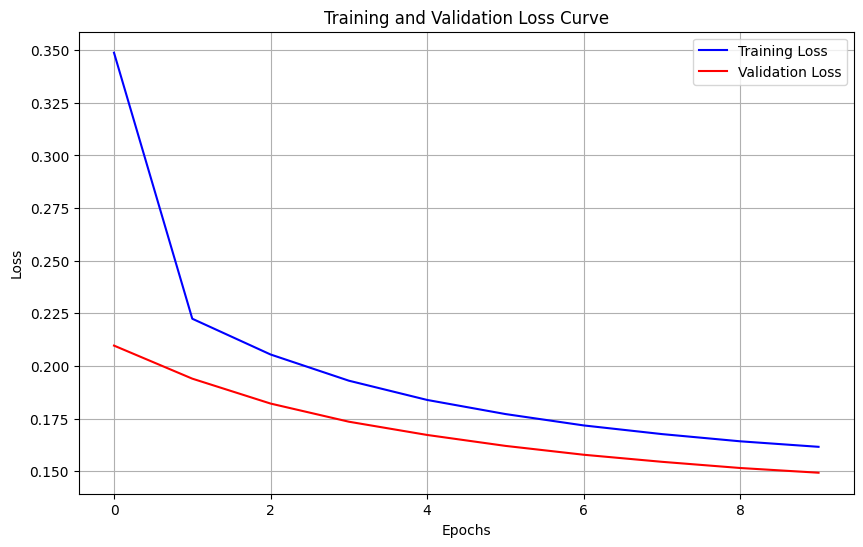

In [8]:
# Initialize lists to track losses
train_losses = []
val_losses = []

model.train()
epochs = 10
steps = 0

# Training loop
for epoch in range(epochs):
    total_train_loss = 0

    progress_bar_train = tqdm(train_loader, desc=f"Training: step {steps}")
    for (batch,) in progress_bar_train:
        torch.cuda.empty_cache()

        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        accelerator.backward(loss) # with accelerator, batch is already on correct device
        optimizer.step()

        # Track loss
        total_train_loss += loss.item()
        steps += 1

    train_losses.append(total_train_loss / len(train_loader.dataset))


    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc="Validating")
        for (batch,) in progress_bar_val:
            torch.cuda.empty_cache()

            outputs = model(batch, labels=batch)
            loss = outputs.loss

            total_val_loss += loss.item()

    val_losses.append(total_val_loss / len(val_loader.dataset))

    # Print current training and validation loss
    print(f"Step {steps} | Train Loss: {total_train_loss / len(train_loader.dataset):.4f} | Val Loss: {total_val_loss / len(val_loader.dataset):.4f}")
    model.train()

# Plotting the loss curves after training is done
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Training Loss", color='blue')
plt.plot(range(epochs), val_losses, label="Validation Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Make prediction

In [9]:
def decode_time_series(generated_text, alpha=0.5, max_time_steps=20):
    """
    Decodes a generated time-series string of texts back into numerical data.

    Args:
        generated_text (str): Preprocessed string in LLMTIME format. e.g. ;6.398,1.204;6.676,1.310;6.891,1.446
        alpha (float): Scaling factor used during preprocessing (default is 0.5).
        max_time_steps (int): Maximum number of time steps to decode (default is 20).

    Returns:
        np.ndarray: Decoded time-series data of shape (T, 2).
    """
    # Remove leading semicolon if it exists
    generated_text = generated_text.lstrip(";")

    # Split the string into time steps and filter out any empty strings
    time_steps = [step for step in generated_text.split(";") if step]

    # Convert each pair of values back to float and reverse scaling
    data = []
    for i, step in enumerate(time_steps):
        if i >= max_time_steps:  # Stop after decoding max_time_steps
            break

        # Check if the step is in the correct format (i.e., contains exactly two values separated by a comma)
        if len(step.split(",")) == 2:
            try:
                prey, predator = map(float, step.split(","))
                data.append([prey * alpha, predator * alpha])
            except ValueError:
                print(f"Skipping invalid data (non-float values): {step}")
        else:
            print(f"Skipping malformed data: {step}")

    return np.array(data, dtype=np.float32)

decode_time_series(';6.398,1.204;6.676,1.310;6.891,1.446') # check the function

array([[3.199 , 0.602 ],
       [3.338 , 0.655 ],
       [3.4455, 0.723 ]], dtype=float32)

System:   0%|          | 0/6 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 18, 23, 11, 15, 13, 24, 15, 18, 26, 19, 13, 24, 24, 22, 11, 15, 13, 24, 22, 15, 26, 19, 13, 24, 23, 18, 11, 16, 13, 15, 21, 18, 26, 19, 13, 22, 22, 23, 11, 16, 13, 16, 18, 20, 26, 19, 13, 19, 24, 19, 11, 16, 13, 16, 21, 15, 26, 19, 13, 16, 18, 24, 11, 16, 13, 16, 19, 18, 26, 18, 13, 23, 20, 23, 11, 16, 13, 15, 20, 24, 26, 18, 13, 21, 15, 17, 11, 15, 13, 24, 21, 23, 26, 18, 13, 19, 16, 24, 11, 15, 13, 23, 23, 21, 26, 18, 13, 17, 23, 19, 11, 15, 13, 23, 15, 17, 26, 18, 13, 17, 16, 15, 11, 15, 13, 22, 16, 17, 26, 18, 13, 17, 15, 18, 11, 15, 13, 21, 17, 22, 26, 18, 13, 17, 19, 22, 11, 15, 13, 20, 20, 20, 26, 18, 13, 18, 18, 22, 11, 15, 13, 20, 15, 20, 26, 18, 13, 19, 21, 18, 11, 15, 13, 19, 22, 23, 26, 18, 13, 21, 15, 22, 11, 15, 13, 19, 22, 15, 26, 18, 13, 22, 20, 20, 11, 15, 13, 19, 22, 15, 26, 18, 13, 23, 22, 24, 11, 15, 13, 19, 23, 15, 26, 18, 13, 24, 22, 19, 11, 15, 13, 20, 15, 16, 26, 19, 13, 15, 17, 15, 11, 15, 13, 20, 19, 18, 26, 19, 13, 15, 19, 1

System:  17%|█▋        | 1/6 [07:07<35:38, 427.77s/it]

generated tokens: [26, 19, 13, 22, 23, 19, 11, 15, 13, 23, 24, 16, 26, 19, 13, 23, 19, 17, 11, 16, 13, 15, 15, 15, 26, 19, 13, 22, 20, 24, 11, 16, 13, 16, 16, 19, 26, 19, 13, 20, 17, 15, 11, 16, 13, 17, 15, 18, 26, 19, 13, 17, 22, 18, 11, 16, 13, 17, 21, 17, 26, 18, 13, 24, 20, 22, 11, 16, 13, 17, 23, 20, 26, 18, 13, 21, 18, 19, 11, 16, 13, 17, 23, 23, 26, 18, 13, 18, 18, 24, 11, 16, 13, 17, 21, 19, 26, 18, 13, 16, 20, 16, 11, 16, 13, 17, 17, 16, 26, 18, 13, 15, 22, 19, 11, 16, 13, 16, 20, 23, 26, 18, 13, 15, 15, 23, 11, 16, 13, 15, 24, 20, 26, 18, 13, 15, 16, 24, 11, 16, 13, 15, 18, 21, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 15164

System:  33%|███▎      | 2/6 [14:15<28:30, 427.74s/it]

generated tokens: [26, 19, 13, 21, 22, 23, 11, 17, 13, 18, 20, 15, 26, 19, 13, 21, 16, 23, 11, 17, 13, 18, 16, 22, 26, 19, 13, 20, 21, 18, 11, 17, 13, 17, 23, 15, 26, 19, 13, 20, 15, 23, 11, 17, 13, 17, 19, 18, 26, 19, 13, 19, 22, 16, 11, 17, 13, 17, 16, 24, 26, 19, 13, 19, 21, 19, 11, 17, 13, 17, 15, 21, 26, 19, 13, 19, 21, 17, 11, 17, 13, 16, 24, 22, 26, 19, 13, 19, 21, 23, 11, 17, 13, 16, 24, 15, 26, 19, 13, 19, 23, 18, 11, 17, 13, 17, 15, 20, 26, 19, 13, 20, 15, 17, 11, 17, 13, 17, 18, 19, 26, 19, 13, 20, 18, 21, 11, 17, 13, 17, 22, 21, 26, 19, 13, 20, 21, 20, 11, 17, 13, 18, 17, 16, 26, 19, 13, 20, 24, 21, 11, 17, 13, 18, 21, 18, 26, 19, 13, 21, 16, 24, 11, 17, 13, 18, 24, 22, 26, 19, 13, 21, 18, 19, 11, 17, 13, 19, 17, 22, 26, 19, 13, 21, 18, 21, 11, 17, 13, 19, 19, 21, 26, 19, 13, 21, 18, 15, 11, 17, 13, 19, 20, 16, 26, 19, 13, 21, 16, 18, 11, 17, 13, 19, 20, 16, 26, 19, 13, 20, 23, 20, 11, 17, 13, 19, 19, 17, 26, 19, 13, 20, 19, 19, 11, 17, 13, 19, 17, 19, 26, 19, 13, 19, 23, 1

System:  50%|█████     | 3/6 [21:23<21:23, 427.73s/it]

generated tokens: [26, 19, 13, 21, 22, 15, 11, 16, 13, 15, 18, 18, 26, 19, 13, 21, 23, 22, 11, 16, 13, 15, 17, 22, 26, 19, 13, 21, 24, 21, 11, 16, 13, 15, 17, 17, 26, 19, 13, 22, 15, 20, 11, 16, 13, 15, 16, 23, 26, 19, 13, 22, 16, 16, 11, 16, 13, 15, 16, 20, 26, 19, 13, 22, 16, 21, 11, 16, 13, 15, 16, 18, 26, 19, 13, 22, 17, 16, 11, 16, 13, 15, 16, 16, 26, 19, 13, 22, 17, 21, 11, 16, 13, 15, 15, 24, 26, 19, 13, 22, 18, 16, 11, 16, 13, 15, 15, 23, 26, 19, 13, 22, 18, 19, 11, 16, 13, 15, 15, 23, 26, 19, 13, 22, 18, 22, 11, 16, 13, 15, 15, 23, 26, 19, 13, 22, 18, 22, 11, 16, 13, 15, 15, 22, 26, 19, 13, 22, 18, 23, 11, 16, 13, 15, 15, 21, 26, 19, 13, 22, 18, 23, 11, 16, 13, 15, 15, 20, 26, 19, 13, 22, 18, 22, 11, 16, 13, 15, 15, 20, 26, 19, 13, 22, 18, 21, 11, 16, 13, 15, 15, 20, 26, 19, 13, 22, 18, 21, 11, 16, 13, 15, 15, 19, 26, 19, 13, 22, 18, 19, 11, 16, 13, 15, 15, 18, 26, 19, 13, 22, 18, 17, 11, 16, 13, 15, 15, 17, 26, 19, 13, 22, 17, 24, 11, 16, 13, 15, 15, 16, 26, 19, 13, 22, 17, 2

System:  67%|██████▋   | 4/6 [28:30<14:15, 427.71s/it]

generated tokens: [26, 17, 13, 16, 15, 19, 11, 15, 13, 18, 15, 17, 26, 17, 13, 21, 22, 23, 11, 15, 13, 18, 16, 19, 26, 18, 13, 18, 16, 19, 11, 15, 13, 18, 19, 15, 26, 18, 13, 24, 16, 24, 11, 15, 13, 18, 24, 15, 26, 19, 13, 18, 20, 24, 11, 15, 13, 19, 21, 20, 26, 19, 13, 18, 20, 21, 11, 15, 13, 20, 22, 19, 26, 18, 13, 22, 15, 24, 11, 15, 13, 21, 24, 16, 26, 18, 13, 15, 19, 18, 11, 15, 13, 23, 17, 24, 26, 17, 13, 17, 20, 23, 11, 15, 13, 24, 20, 19, 26, 16, 13, 20, 17, 19, 11, 16, 13, 15, 22, 16, 26, 16, 13, 15, 21, 17, 11, 16, 13, 16, 17, 21, 26, 15, 13, 23, 23, 23, 11, 16, 13, 16, 20, 15, 26, 15, 13, 22, 21, 21, 11, 16, 13, 16, 17, 23, 26, 15, 13, 21, 24, 17, 11, 16, 13, 15, 21, 24, 26, 15, 13, 21, 20, 19, 11, 15, 13, 24, 24, 20, 26, 15, 13, 21, 19, 15, 11, 15, 13, 23, 23, 18, 26, 15, 13, 21, 20, 21, 11, 15, 13, 22, 22, 22, 26, 15, 13, 22, 16, 24, 11, 15, 13, 21, 23, 17, 26, 15, 13, 23, 19, 21, 11, 15, 13, 21, 15, 16, 26, 16, 13, 15, 24, 15, 11, 15, 13, 20, 19, 23, 26, 16, 13, 19, 17, 1

System:  83%|████████▎ | 5/6 [36:00<07:15, 435.67s/it]

generated tokens: [26, 16, 19, 13, 18, 15, 24, 11, 15, 13, 15, 23, 23, 26, 16, 19, 13, 18, 16, 15, 11, 15, 13, 15, 23, 22, 26, 16, 19, 13, 18, 16, 16, 11, 15, 13, 15, 23, 22, 26, 16, 19, 13, 18, 16, 17, 11, 15, 13, 15, 23, 21, 26, 16, 19, 13, 18, 16, 18, 11, 15, 13, 15, 23, 21, 26, 16, 19, 13, 18, 16, 19, 11, 15, 13, 15, 23, 20, 26, 16, 19, 13, 18, 16, 19, 11, 15, 13, 15, 23, 20, 26, 16, 19, 13, 18, 16, 20, 11, 15, 13, 15, 23, 20, 26, 16, 19, 13, 18, 16, 21, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 16, 21, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 16, 22, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 16, 23, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 16, 23, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 16, 23, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 16, 24, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 17, 15, 11, 15, 13, 15, 23, 18, 26, 16, 19, 13, 18, 17, 15, 11, 15, 13, 15, 23, 18, 26, 16, 19, 13, 18, 17, 15, 11, 15, 13, 15, 23, 18, 26, 16, 19, 13, 18, 17, 16, 11, 15, 13, 15, 2

System: 100%|██████████| 6/6 [43:08<00:00, 431.39s/it]

generated tokens: [26, 15, 13, 19, 23, 21, 11, 16, 13, 16, 15, 17, 26, 15, 13, 19, 22, 23, 11, 15, 13, 23, 24, 21, 26, 15, 13, 20, 15, 22, 11, 15, 13, 22, 23, 23, 26, 15, 13, 20, 24, 16, 11, 15, 13, 22, 15, 16, 26, 15, 13, 22, 21, 15, 11, 15, 13, 21, 18, 22, 26, 15, 13, 24, 23, 19, 11, 15, 13, 20, 23, 24, 26, 16, 13, 17, 21, 15, 11, 15, 13, 20, 19, 22, 26, 16, 13, 20, 22, 21, 11, 15, 13, 20, 17, 23, 26, 16, 13, 24, 19, 20, 11, 15, 13, 20, 17, 15, 26, 17, 13, 19, 19, 15, 11, 15, 13, 20, 18, 21, 26, 17, 13, 24, 18, 21, 11, 15, 13, 20, 22, 19, 26, 18, 13, 19, 21, 15, 11, 15, 13, 21, 22, 17, 26, 18, 13, 23, 19, 16, 11, 15, 13, 23, 17, 19, 26, 19, 13, 15, 18, 15, 11, 16, 13, 15, 24, 22, 26, 18, 13, 20, 16, 23, 11, 16, 13, 19, 23, 19, 26, 17, 13, 19, 22, 21, 11, 16, 13, 24, 18, 18, 26, 16, 13, 20, 22, 15, 11, 17, 13, 16, 20, 21, 26, 16, 13, 15, 18, 18, 11, 16, 13, 24, 19, 22, 26, 15, 13, 22, 17, 17, 11, 16, 13, 21, 20, 21, 26, 15, 13, 20, 22, 24, 11, 16, 13, 18, 19, 23, 26, 15, 13, 20, 16, 1

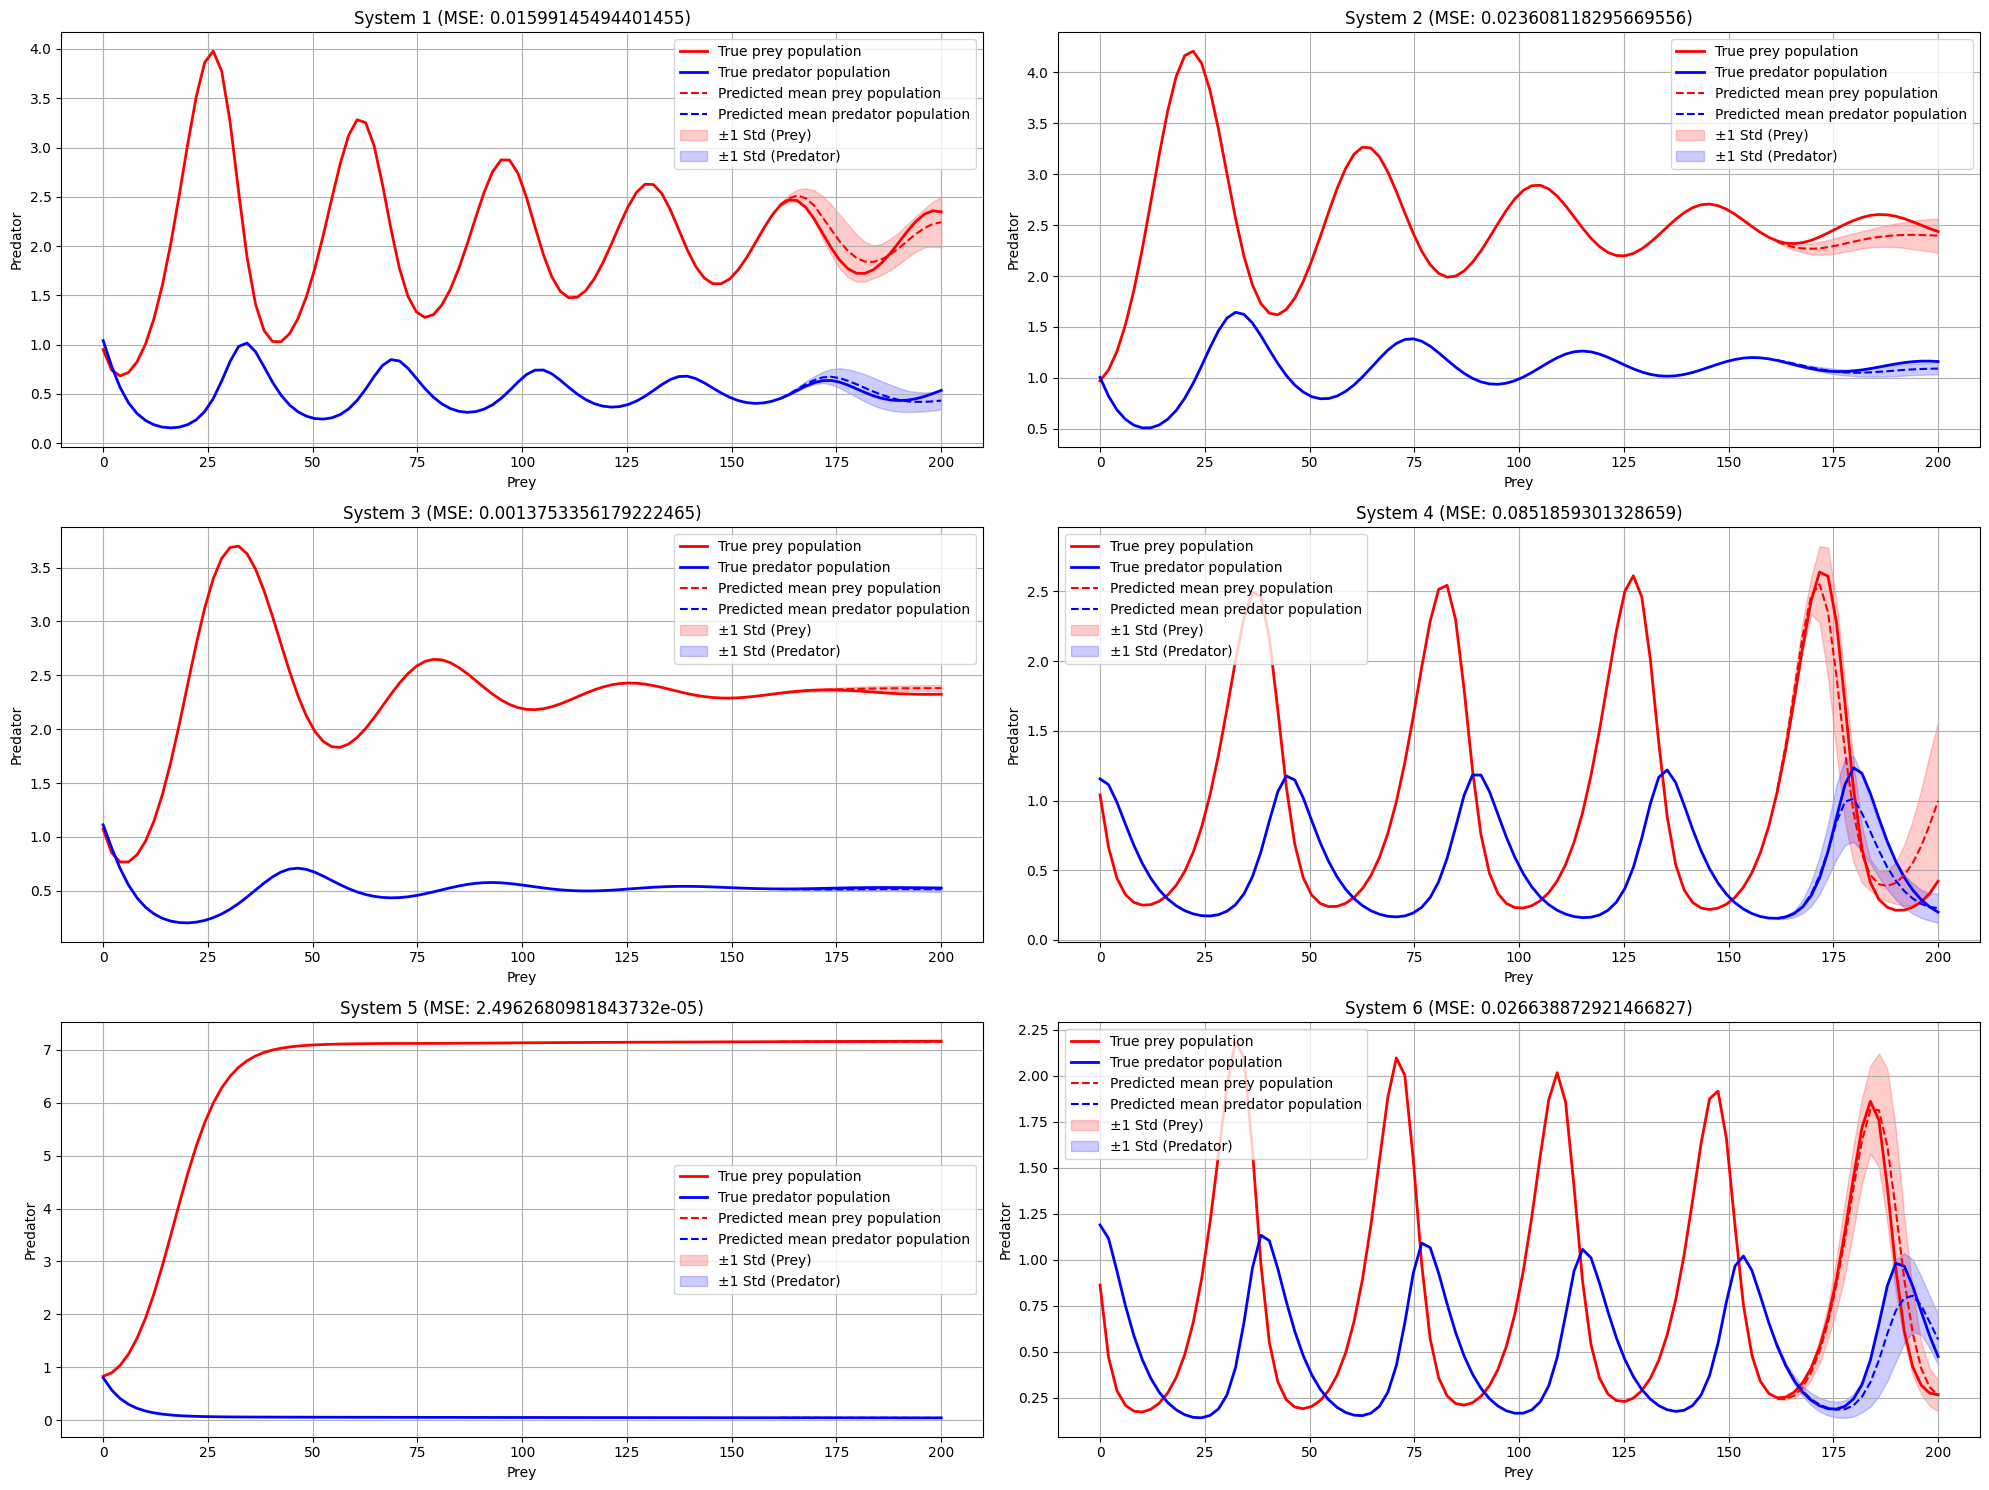

In [16]:
def plot_predictions(model, accelerator, tokenizer):
    plt.figure(figsize=(20, 15))

    device = accelerator.device

    model.eval()

    for system_id in tqdm(range(6), desc="System"):
        prey = trajectories[system_id, :, 0] # a list of 100 points for population of prey
        predator = trajectories[system_id, :, 1] # a list of 100 points for population of predator

        raw_data = np.column_stack((prey[:80], predator[:80])) # only stack the first 80 time steps (shape: (80,2))

        preprocessed_text = preprocess_time_series(raw_data) # apply LLMTIME scheme to convert raw data to texts

        tokenized_input = tokenize_sequence(preprocessed_text)  # use Qwen2.5 to tokenize the text (looks like [17, 13, ...])

        # Generate predictions (repeat for stochastic models to get variance)
        num_samples = 10  # Number of samples to estimate uncertainty
        num_tokens = 500 # predict 20 time steps need many tokens (for decimal=3)
        preds = []

        for _ in range(num_samples):
            input_tensor = torch.tensor(tokenized_input, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

            # Autoregressive prediction for next num_token number of tokens
            generated_tokens = []
            for _ in range(num_tokens):
                with torch.no_grad():
                    output = model(input_tensor)
                    # next_token = output.logits[:, -1, :].argmax(dim=-1).unsqueeze(0)  # Get most likely next token

                    # Define temperature for randomness (variability) to the autoregressive predictions
                    temperature = 1.0  # You can experiment with higher values (1.0) or lower (0.5) for more randomness
                    logits = output.logits[:, -1, :] / temperature  # Adjust logits with temperature
                    probs = torch.nn.functional.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)  # Sample from the distribution

                    generated_tokens.append(next_token.item())

                    # Append predicted token to input for next step
                    input_tensor = torch.cat([input_tensor, next_token], dim=1) # final form: tensor([[17, 18, 13, ...]])

            # Decode generated tokens back to time series data
            print(f"generated tokens: {generated_tokens}")
            generated_text = tokenizer.decode(generated_tokens)
            print(f"generated text: {generated_text}")

            generated_series = decode_time_series(generated_text)  # Convert texts back to numerical series and truncate the series at 100 time step
            # print(f"generated time series: {generated_series}")

            # Only add if the shape is correct and no NaNs are present
            if generated_series is not None and generated_series.shape == (20, 2) and not np.isnan(generated_series).any():
                preds.append(generated_series)
            else:
                print(f"Skipping invalid sample with shape: {generated_series.shape}")


        preds = np.array(preds)  # Shape: (num_samples, T=20, 2)
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)

        # Calculate the MSE for each system
        prey_mse = np.mean((mean_pred[:, 0] - prey[80:]) ** 2)
        predator_mse = np.mean((mean_pred[:, 1] - predator[80:]) ** 2)
        total_mse = prey_mse + predator_mse
        print(f"The MSE for system {system_id + 1} is: {total_mse}")

        # Plot true series
        plt.subplot(3, 2, system_id + 1)
        plt.plot(time_points, prey, label=f'True prey population', color='red', linewidth=2)
        plt.plot(time_points, predator, label=f'True predator population', color='blue', linewidth=2)

        # Plot predicted mean with dashed line
        plt.plot(time_points[80:], mean_pred[:, 0], label='Predicted mean prey population', color='red', linestyle='--')
        plt.plot(time_points[80:], mean_pred[:, 1], label='Predicted mean predator population', color='blue', linestyle='--')

        # Plot shaded area for 1 standard deviation
        plt.fill_between(time_points[80:],
                        mean_pred[:, 0] - std_pred[:, 0],
                        mean_pred[:, 0] + std_pred[:, 0],
                        color='red', alpha=0.2, label='±1 Std (Prey)')

        plt.fill_between(time_points[80:],
                 mean_pred[:, 1] - std_pred[:, 1],
                 mean_pred[:, 1] + std_pred[:, 1],
                 color='blue', alpha=0.2, label='±1 Std (Predator)')


        plt.title(f'System {system_id + 1} (MSE: {total_mse})')
        plt.xlabel('Prey')
        plt.ylabel('Predator')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function after training with tokenization
accelerator = Accelerator()
plot_predictions(model, accelerator, tokenizer)
